# Capstone

This is specially for the project _capstone_

In [1]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


## Introduction

The GDP of a region can be inflected in many aspects, including the urbanization rate and the average life span of the region. In a word, the higher the urbanization rate is, the higher the average life span is, more likely is that the GDP of the region is higher. 
So, as we have learn to explore the neighborhoods of a city, I wonder if the vary type of the venue in the neighborhood can be a reflection. To be explicitly, if the rate that cafe takes of the total venues is higher in a same cultural environment, the more likely the GDP tends to be higher, because the the need for unnecessaries imply that people are more healthy. 
In my research, I'm going to verify my hypothesis.

### The data used

1. Location data. I will be using the location data of the various cities selected as the training group.   
2. GDP data. I will have to gather the GDP data from some official websites.   
3. Foursqure API. The API play a major part in explore the neighborhood of the city.

In [2]:
import json
import pandas as pd 
import numpy as np
import xlrd
import requests
from pandas.io.json import json_normalize
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
import matplotlib.pyplot as plt

In [3]:
with open('geoinfo-all.json') as json_data:
    china_data = json.load(json_data)
print("geoinfo successfully loaded!")

geoinfo successfully loaded!


In [4]:
china_data[0]['name']

'北京市'

In [5]:
i=1
for province in china_data:
    for city in province['districts']:
#         print(city['name'],i)
        i+=1
print(i," city in total")

396  city in total


we could see there is 395 cities in China.

## clean and get together the data

In [6]:
columns = ['city','x','y','gdp_per_capta']

In [7]:
data = pd.DataFrame(columns = columns)

In [8]:
data.head()

,city,x,y,gdp_per_capta


In [9]:
gdp = xlrd.open_workbook('2015-2017GDP.xlsx')
gdp.sheet_names()
table = gdp.sheet_by_index(1)
city = table.col_values(1)[1:]
p_gdp = table.col_values(3)[1:]
g = {c:d for c,d in zip(city,p_gdp)}
print("GDP per capita of 石家庄市 ：",g['石家庄市'])

GDP per capita of 石家庄市 ： 59645.0


open the GDP file and get the data of GDP of each city.

In [10]:
for province in china_data:
    for city in province['districts']:
        if city['name'] in g.keys():
#             print(city['name'])
            data = data.append({'city' : city['name'],
                         'x' : city['center'].split(',')[0],
                         'y' : city['center'].split(',')[1],
                         'gdp_per_capta' : g[city['name']]
                        },ignore_index= True)

Now we can get the coordinations and GDP data together

In [11]:
print(data.shape)
data.head()

(149, 4)


,city,x,y,gdp_per_capta
0,石家庄市,114.514793,38.042228,59645.0
1,唐山市,118.180193,39.630867,90290.0
2,秦皇岛市,119.518197,39.888701,48539.0
3,邯郸市,114.538959,36.625594,38585.0
4,邢台市,114.504677,37.070834,30486.0


We could find the number of data does not match the number of city we initially count, that is for the reason that some

In [12]:
CLIENT_ID = 'PSUI5HTST3BUOACVFELLPJVQFNXDKGLITSISKQ4BEQIQXASS' # your Foursquare ID
CLIENT_SECRET = 'P2HZLUJ4TXDDIGFNRCPXOS35DJAG4ZEVFNQUFV2Z2A3A0JE1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [13]:
for bo, la ,lo in zip(data['city'],data['x'],data['y']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lo, 
    la, 
    5000, 
    20)
print(url)

https://api.foursquare.com/v2/venues/explore?&client_id=PSUI5HTST3BUOACVFELLPJVQFNXDKGLITSISKQ4BEQIQXASS&client_secret=P2HZLUJ4TXDDIGFNRCPXOS35DJAG4ZEVFNQUFV2Z2A3A0JE1&v=20180605&ll=30.128901,104.627636&radius=5000&limit=20


In [14]:
results = requests.get(url).json()
results['response']['groups'][0]['items'][0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '578b3193498eb4b2f5eaf454',
  'name': 'Wanda Plaza (万达广场)',
  'location': {'lat': 30.130641,
   'lng': 104.61853,
   'labeledLatLngs': [{'label': 'display',
     'lat': 30.130641,
     'lng': 104.61853}],
   'distance': 897,
   'cc': 'CN',
   'city': '雁江',
   'state': '四川',
   'country': '中国',
   'formattedAddress': ['雁江', '四川', '中国']},
  'categories': [{'id': '4bf58dd8d48988d1fd941735',
    'name': 'Shopping Mall',
    'pluralName': 'Shopping Malls',
    'shortName': 'Mall',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/mall_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-0-578b3193498eb4b2f5eaf454-0'}

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print(nearby_venues.shape)
nearby_venues.head()

(8, 4)


<ipython-input-16-4fa96f81f802>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Wanda Plaza (万达广场),Shopping Mall,30.130641,104.618530
1,波波兔儿面,Szechuan Restaurant,30.126538,104.620496
2,Jinjiang Shuheng Hotel,Hotel,30.129404,104.609438
3,Shuhen Jin Hotel,Hotel,30.132418,104.609424
4,南门市场,Market,30.112903,104.650748


In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

8 venues were returned by Foursquare.


In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name,end='\t')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except Keyerror:
            continue
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
venues = getNearbyVenues(names=data['city'],
                                   latitudes=data['y'],
                                   longitudes=data['x'],
                                   radius = 10000
                                  )

石家庄市	唐山市	秦皇岛市	邯郸市	邢台市	保定市	张家口市	承德市	沧州市	廊坊市	衡水市	太原市	大同市	阳泉市	长治市	晋城市	朔州市	晋中市	运城市	忻州市	临汾市	吕梁市	南京市	无锡市	徐州市	常州市	苏州市	南通市	连云港市	淮安市	盐城市	扬州市	镇江市	泰州市	宿迁市	杭州市	宁波市	温州市	嘉兴市	湖州市	绍兴市	金华市	衢州市	舟山市	台州市	丽水市	福州市	厦门市	莆田市	三明市	泉州市	漳州市	南平市	龙岩市	宁德市	济南市	青岛市	淄博市	枣庄市	东营市	烟台市	潍坊市	济宁市	泰安市	威海市	日照市	莱芜市	临沂市	德州市	聊城市	滨州市	菏泽市	武汉市	黄石市	十堰市	宜昌市	襄阳市	鄂州市	荆门市	孝感市	荆州市	黄冈市	咸宁市	随州市	恩施土家族苗族自治州	长沙市	株洲市	湘潭市	衡阳市	邵阳市	岳阳市	常德市	张家界市	益阳市	郴州市	永州市	怀化市	娄底市	湘西土家族苗族自治州	广州市	韶关市	深圳市	珠海市	汕头市	佛山市	江门市	湛江市	茂名市	肇庆市	惠州市	梅州市	汕尾市	河源市	阳江市	清远市	东莞市	中山市	潮州市	揭阳市	云浮市	澄迈县	海口市	三亚市	儋州市	定安县	东方市	临高县	琼海市	屯昌县	万宁市	文昌市	五指山市	成都市	自贡市	攀枝花市	泸州市	德阳市	绵阳市	广元市	遂宁市	内江市	乐山市	南充市	眉山市	宜宾市	广安市	达州市	雅安市	资阳市	

In [20]:
venues.shape

(2255, 7)

In [21]:
venues["Venue Category"].value_counts()[-20:]

Airport Lounge              1
Donut Shop                  1
Arcade                      1
Outdoor Supply Store        1
Dive Bar                    1
Baby Store                  1
Toll Plaza                  1
Casino                      1
Shanxi Restaurant           1
Soccer Field                1
Event Space                 1
Bubble Tea Shop             1
Racetrack                   1
Playground                  1
Mediterranean Restaurant    1
Cave                        1
Pie Shop                    1
Halal Restaurant            1
Nature Preserve             1
Intersection                1
Name: Venue Category, dtype: int64

In [22]:
venues.groupby('Neighborhood').count().sort_values("Neighborhood Latitude")

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
屯昌县,1,1,1,1,1,1
澄迈县,1,1,1,1,1,1
滨州市,3,3,3,3,3,3
定安县,3,3,3,3,3,3
儋州市,3,3,3,3,3,3
...,...,...,...,...,...,...
杭州市,100,100,100,100,100,100
南京市,100,100,100,100,100,100
深圳市,100,100,100,100,100,100


In [23]:
manhattan_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['city'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,city,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Asian Restaurant,...,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Xinjiang Restaurant,Zhejiang Restaurant,Zoo
0,石家庄市,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,石家庄市,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,石家庄市,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,石家庄市,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,石家庄市,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
manhattan_onehot.shape

(2255, 205)

In [27]:
manhattan_grouped = manhattan_onehot.groupby('city').mean().reset_index()
manhattan_grouped

,city,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Asian Restaurant,...,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Xinjiang Restaurant,Zhejiang Restaurant,Zoo
0,万宁市,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,三亚市,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.032787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,三明市,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,东方市,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,东莞市,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,青岛市,0.0,0.0,0.0,0.014085,0.028169,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,韶关市,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,黄冈市,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,黄石市,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
num_top_venues = 5

for hood in manhattan_grouped['city'][:5]:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['city'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----万宁市----
                  venue  freq
0          Intersection  0.25
1    Chinese Restaurant  0.25
2  Fast Food Restaurant  0.25
3         Train Station  0.25
4     Afghan Restaurant  0.00


----三亚市----
                  venue  freq
0                 Hotel  0.15
1                Resort  0.11
2  Fast Food Restaurant  0.08
3           Pizza Place  0.05
4                 Beach  0.05


----三明市----
              venue  freq
0             Hotel  0.50
1       Pizza Place  0.25
2    Shopping Plaza  0.25
3  Pedestrian Plaza  0.00
4      Neighborhood  0.00


----东方市----
               venue  freq
0      Train Station   0.4
1              Beach   0.2
2    Harbor / Marina   0.2
3        Bus Station   0.2
4  Afghan Restaurant   0.0


----东莞市----
                  venue  freq
0           Coffee Shop  0.22
1  Fast Food Restaurant  0.12
2    Italian Restaurant  0.10
3           Pizza Place  0.07
4                 Hotel  0.07




In [30]:
## linear regression
selected_venues = list(manhattan_grouped.iloc[:,1:].var().sort_values(ascending =False)[:5].index)
city_grouped = manhattan_grouped[['city']+selected_venues]
city_grouped[city_grouped.sum(axis =1)>0.5]
data_all = pd.merge(data,city_grouped,left_on= 'city',right_on = 'city')
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asarray(data_all.loc[:100,selected_venues])
y = np.asarray(data_all.loc[:100,'gdp_per_capta'])
regr.fit(x,y)
y_hat= regr.predict(data_all.loc[100:,selected_venues])
x_test = np.asarray(data_all.loc[100:,selected_venues])
y_test = np.asarray(data_all.loc[100:,'gdp_per_capta'])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test))

Residual sum of squares: 1316241803.28
Variance score: -0.28


(array([ 0.,  3., 21., 10.,  6.,  1.,  4.,  1.,  0.,  1.,  0.,  1.,  0.,
         1.,  0.]),
 array([     0.        ,  13333.33333333,  26666.66666667,  40000.        ,
         53333.33333333,  66666.66666667,  80000.        ,  93333.33333333,
        106666.66666667, 120000.        , 133333.33333333, 146666.66666667,
        160000.        , 173333.33333333, 186666.66666667, 200000.        ]),
 <a list of 15 Patch objects>)

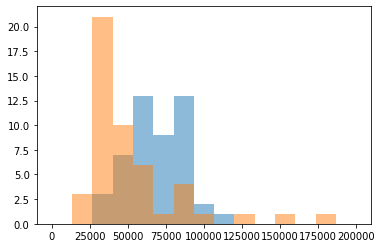

In [31]:
m = pd.DataFrame({'y_hat':y_hat,'y_test':y_test})
plt.hist(m.y_hat,15,[0,200000],alpha = 0.5)
plt.hist(m.y_test,15,[0,200000],alpha = 0.5)

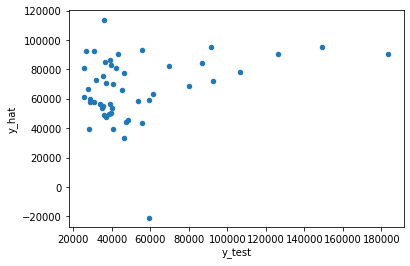

In [32]:
m.plot(kind = 'scatter',x = 'y_test',y = 'y_hat')

In [33]:
# ## GBDT regression
selected_venues = list(manhattan_grouped.iloc[:,1:].var().sort_values(ascending =False)[:5].index)
city_grouped = manhattan_grouped[['city']+selected_venues]
city_grouped[city_grouped.sum(axis =1)>0.5]
data_all = pd.merge(data,city_grouped,left_on= 'city',right_on = 'city')


gbr = GradientBoostingRegressor(n_estimators= 200,learning_rate= 0.1)
x = np.asarray(data_all.loc[:100,selected_venues])
y = np.asarray(data_all.loc[:100,'gdp_per_capta'])
gbr.fit(x,y)
y_hat= gbr.predict(data_all.loc[100:,selected_venues])
x_test = np.asarray(data_all.loc[100:,selected_venues])
y_test = np.asarray(data_all.loc[100:,'gdp_per_capta'])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % gbr.score(x_test, y_test))

Residual sum of squares: 711298913.72
Variance score: 0.31


(array([ 0.,  3., 21., 10.,  6.,  1.,  4.,  1.,  0.,  1.,  0.,  1.,  0.,
         1.,  0.]),
 array([     0.        ,  13333.33333333,  26666.66666667,  40000.        ,
         53333.33333333,  66666.66666667,  80000.        ,  93333.33333333,
        106666.66666667, 120000.        , 133333.33333333, 146666.66666667,
        160000.        , 173333.33333333, 186666.66666667, 200000.        ]),
 <a list of 15 Patch objects>)

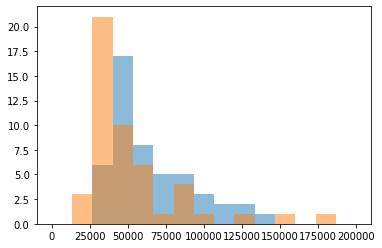

In [34]:
m = pd.DataFrame({'y_hat':y_hat,'y_test':y_test})
plt.hist(m.y_hat,15,[0,200000],alpha = 0.5)
plt.hist(m.y_test,15,[0,200000],alpha = 0.5)

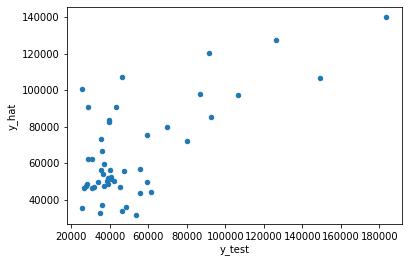

In [35]:
m.plot(kind = 'scatter',x = 'y_test',y = 'y_hat')